# Data Based Vehicle Energy Consumption Modeling
---
* In this project, we have a real data set at hand which consists of various features regarding driving profiles of electric delivery trucks. The goal of this project is to investigate this data, and better understand some characteristics of electric vehicles as well as their energy consumption.

* This is a data analysis project. The students will

> 1.  Perform data cleaning and preprocessing
> 2.  Perform clustering to catch some patterns in the data
> 3.  Use concepts from machine learning for a detailed investigation of the data
> 4.  Perform visualization to present the outcomes of their investigation

*   **Students**: Mert Kılıçaslan, Serhan Yorulmaz, Yunus Delipınar
*   **Supervisors**: Tuğçe Yüksel, Öznur Taştan, Mert Özçelik

## 0.1. Import Libraries

In [6]:
from os.path import join
import os
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io import loadmat
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
pd.options.mode.chained_assignment = None

from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
import math

from sklearn.metrics import classification_report,accuracy_score, confusion_matrix, mean_squared_error, make_scorer, mean_absolute_error, mean_absolute_percentage_error

In [7]:
#from google.colab import drive
#drive.mount('/content/drive')

## 0.2. Understanding data

In [8]:
# Shortcut of the 'ENS491 / F22' file must be added to My Drive
path_prefix = "../Smith_Gen2 Vehicles Data/vehicle_113"
fname = "device_071_2013-10-14.mat" 

In [9]:
mat = loadmat(join(path_prefix, fname))
mat = {k:v for k, v in mat.items() if k[0] != '_'}
df = pd.DataFrame({k: np.array(v).flatten() for k, v in mat.items()})

df

,Act1_Iacm_CA,Act1_Iacm_CB,ms_nmot,Lowest_Cell_Voltage_SBS3,Lowest_Cell_Voltage_SBS2,Lowest_Cell_Voltage_SBS1,Lowest_Cell_Voltage_SBS6,Lowest_Cell_Voltage_SBS5,VS_DCMD,SOC_SYS,...,BMU_Mode_SYS,CT_Air_Con_Current_RD,ms_tmc1,Lowest_Cell_Temperature_SBS6,ms_ths5,vs_bcmd,GPS_Longitude,ms_ths1,ms_ths3,ms_ths2
0,0.0,NaN,NaN,3336.0,3338.0,3337.0,NaN,NaN,NaN,100.0,...,1.0,NaN,NaN,NaN,NaN,NaN,-117.926653,NaN,NaN,NaN
1,0.0,NaN,NaN,3336.0,3338.0,3337.0,NaN,NaN,NaN,100.0,...,1.0,NaN,NaN,NaN,NaN,NaN,-117.926653,NaN,NaN,NaN
2,0.0,NaN,NaN,3336.0,3338.0,3337.0,NaN,NaN,NaN,100.0,...,1.0,NaN,NaN,NaN,NaN,NaN,-117.926649,NaN,NaN,NaN
3,0.0,NaN,NaN,3336.0,3338.0,3337.0,NaN,NaN,NaN,100.0,...,1.0,NaN,NaN,NaN,NaN,NaN,-117.926647,NaN,NaN,NaN
4,0.0,NaN,NaN,3336.0,3338.0,3337.0,NaN,NaN,NaN,100.0,...,1.0,2475.0,NaN,NaN,NaN,NaN,-117.926646,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86338,18.7,NaN,0.0,3362.0,3366.0,3366.0,NaN,NaN,0.0,100.0,...,1.0,2475.0,57.0,NaN,32.0,0.0,-117.926578,33.0,34.0,34.0
86339,18.7,NaN,0.0,3362.0,3366.0,3367.0,NaN,NaN,0.0,100.0,...,1.0,2475.0,57.0,NaN,32.0,0.0,-117.926577,33.0,34.0,34.0
86340,19.1,NaN,0.0,3362.0,3366.0,3367.0,NaN,NaN,0.0,100.0,...,1.0,2475.0,57.0,NaN,32.0,0.0,-117.926576,33.0,34.0,34.0
86341,18.9,NaN,0.0,3362.0,3366.0,3366.0,NaN,NaN,0.0,100.0,...,1.0,2475.0,57.0,NaN,32.0,0.0,-117.926575,33.0,34.0,34.0


In [10]:
# [i for i in df.columns]

## 0.3. Taking Relevant Features

In [11]:
# Select the desired columns from the dataframe
df = df[['GPS_Latitude', 'GPS_Longitude','BMU_Mode_SYS','GPS_Speed','Battery_Voltage_SYS','Battery_Current_SYS','Timestamp','RD_Ambient_Temp_degC', "SOC_SYS", "CT_Air_Con_Current_RD", "CT_Heater_Current_RD",'GPS_Altitude']]

# Time decryption (np.float64 to dateTime)
df["Timestamp"] = pd.to_datetime(df['Timestamp'], unit='s')

# Calculate the second difference between current and next row convert into date time seconds
df['Seconds difference'] = df['Timestamp'].diff().dt.total_seconds()

# Calculate the cumulative sum of the time differences for total duration
df['Total Time(s)'] = df['Seconds difference'].cumsum()
# df.at[0, "Total Time(s)"] = 0 # Index 0 to NaN value for the first row

# Calculate the second difference between current and next row convert into date time seconds
df['Altitude_diff'] = df['GPS_Altitude'].diff()
# df.at[0, "Altitude_diff"] = 0

# Multiplying current and voltage to find power consumption
df['Power(w)'] = df['Battery_Voltage_SYS'] * df['Battery_Current_SYS'] * -1

# Drop the rows where BMU = 0 or BMU = 1
df = df[df['BMU_Mode_SYS'] == 2.0] # Battery Management Unit

df

,GPS_Latitude,GPS_Longitude,BMU_Mode_SYS,GPS_Speed,Battery_Voltage_SYS,Battery_Current_SYS,Timestamp,RD_Ambient_Temp_degC,SOC_SYS,CT_Air_Con_Current_RD,CT_Heater_Current_RD,GPS_Altitude,Seconds difference,Total Time(s),Altitude_diff,Power(w)
49339,33.695934,-117.926614,2.0,0.0,0.0,0.0,2013-10-14 19:42:36,18.0,0.0,2481.0,NaN,25.0,1.0,49339.0,0.0,-0.0
49340,33.695930,-117.926615,2.0,0.0,0.0,0.0,2013-10-14 19:42:37,18.0,0.0,2481.0,NaN,24.0,1.0,49340.0,-1.0,-0.0
49341,33.695928,-117.926616,2.0,0.0,346.0,-2.0,2013-10-14 19:42:38,18.0,99.0,2481.0,NaN,24.0,1.0,49341.0,0.0,692.0
49342,33.695926,-117.926617,2.0,0.0,346.0,-1.0,2013-10-14 19:42:39,18.0,99.0,2481.0,NaN,23.0,1.0,49342.0,-1.0,346.0
49343,33.695924,-117.926619,2.0,0.0,346.0,0.0,2013-10-14 19:42:40,18.0,99.0,2481.0,NaN,23.0,1.0,49343.0,0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69089,33.696201,-117.928057,2.0,0.0,340.0,-5.0,2013-10-15 01:11:46,30.0,62.0,2475.0,NaN,12.0,1.0,69089.0,0.0,1700.0
69090,33.696201,-117.928057,2.0,0.0,340.0,-6.0,2013-10-15 01:11:47,30.0,62.0,2475.0,NaN,12.0,1.0,69090.0,0.0,2040.0
69091,33.696201,-117.928057,2.0,0.0,340.0,-3.0,2013-10-15 01:11:48,30.0,62.0,2475.0,NaN,12.0,1.0,69091.0,0.0,1020.0
69092,33.696201,-117.928057,2.0,0.0,340.0,-3.0,2013-10-15 01:11:49,30.0,62.0,2475.0,NaN,12.0,1.0,69092.0,0.0,1020.0


## 0.4. Advanced Operations (Splitting Trips)

In [12]:
# Partiton the data to trips by using Total Time(s)
df_trip = df
df_trip['Trip_diff'] = df_trip["Total Time(s)"].diff()
df_trip["Trip"] = (df_trip['Trip_diff'] > 1000).cumsum() + 1

df_trip

,GPS_Latitude,GPS_Longitude,BMU_Mode_SYS,GPS_Speed,Battery_Voltage_SYS,Battery_Current_SYS,Timestamp,RD_Ambient_Temp_degC,SOC_SYS,CT_Air_Con_Current_RD,CT_Heater_Current_RD,GPS_Altitude,Seconds difference,Total Time(s),Altitude_diff,Power(w),Trip_diff,Trip
49339,33.695934,-117.926614,2.0,0.0,0.0,0.0,2013-10-14 19:42:36,18.0,0.0,2481.0,NaN,25.0,1.0,49339.0,0.0,-0.0,NaN,1
49340,33.695930,-117.926615,2.0,0.0,0.0,0.0,2013-10-14 19:42:37,18.0,0.0,2481.0,NaN,24.0,1.0,49340.0,-1.0,-0.0,1.0,1
49341,33.695928,-117.926616,2.0,0.0,346.0,-2.0,2013-10-14 19:42:38,18.0,99.0,2481.0,NaN,24.0,1.0,49341.0,0.0,692.0,1.0,1
49342,33.695926,-117.926617,2.0,0.0,346.0,-1.0,2013-10-14 19:42:39,18.0,99.0,2481.0,NaN,23.0,1.0,49342.0,-1.0,346.0,1.0,1
49343,33.695924,-117.926619,2.0,0.0,346.0,0.0,2013-10-14 19:42:40,18.0,99.0,2481.0,NaN,23.0,1.0,49343.0,0.0,-0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69089,33.696201,-117.928057,2.0,0.0,340.0,-5.0,2013-10-15 01:11:46,30.0,62.0,2475.0,NaN,12.0,1.0,69089.0,0.0,1700.0,1.0,2
69090,33.696201,-117.928057,2.0,0.0,340.0,-6.0,2013-10-15 01:11:47,30.0,62.0,2475.0,NaN,12.0,1.0,69090.0,0.0,2040.0,1.0,2
69091,33.696201,-117.928057,2.0,0.0,340.0,-3.0,2013-10-15 01:11:48,30.0,62.0,2475.0,NaN,12.0,1.0,69091.0,0.0,1020.0,1.0,2
69092,33.696201,-117.928057,2.0,0.0,340.0,-3.0,2013-10-15 01:11:49,30.0,62.0,2475.0,NaN,12.0,1.0,69092.0,0.0,1020.0,1.0,2


In [13]:
df_trip['test'] = df_trip['BMU_Mode_SYS'] * df_trip['BMU_Mode_SYS'].shift(-1)
df_trip

,GPS_Latitude,GPS_Longitude,BMU_Mode_SYS,GPS_Speed,Battery_Voltage_SYS,Battery_Current_SYS,Timestamp,RD_Ambient_Temp_degC,SOC_SYS,CT_Air_Con_Current_RD,CT_Heater_Current_RD,GPS_Altitude,Seconds difference,Total Time(s),Altitude_diff,Power(w),Trip_diff,Trip,test
49339,33.695934,-117.926614,2.0,0.0,0.0,0.0,2013-10-14 19:42:36,18.0,0.0,2481.0,NaN,25.0,1.0,49339.0,0.0,-0.0,NaN,1,4.0
49340,33.695930,-117.926615,2.0,0.0,0.0,0.0,2013-10-14 19:42:37,18.0,0.0,2481.0,NaN,24.0,1.0,49340.0,-1.0,-0.0,1.0,1,4.0
49341,33.695928,-117.926616,2.0,0.0,346.0,-2.0,2013-10-14 19:42:38,18.0,99.0,2481.0,NaN,24.0,1.0,49341.0,0.0,692.0,1.0,1,4.0
49342,33.695926,-117.926617,2.0,0.0,346.0,-1.0,2013-10-14 19:42:39,18.0,99.0,2481.0,NaN,23.0,1.0,49342.0,-1.0,346.0,1.0,1,4.0
49343,33.695924,-117.926619,2.0,0.0,346.0,0.0,2013-10-14 19:42:40,18.0,99.0,2481.0,NaN,23.0,1.0,49343.0,0.0,-0.0,1.0,1,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69089,33.696201,-117.928057,2.0,0.0,340.0,-5.0,2013-10-15 01:11:46,30.0,62.0,2475.0,NaN,12.0,1.0,69089.0,0.0,1700.0,1.0,2,4.0
69090,33.696201,-117.928057,2.0,0.0,340.0,-6.0,2013-10-15 01:11:47,30.0,62.0,2475.0,NaN,12.0,1.0,69090.0,0.0,2040.0,1.0,2,4.0
69091,33.696201,-117.928057,2.0,0.0,340.0,-3.0,2013-10-15 01:11:48,30.0,62.0,2475.0,NaN,12.0,1.0,69091.0,0.0,1020.0,1.0,2,4.0
69092,33.696201,-117.928057,2.0,0.0,340.0,-3.0,2013-10-15 01:11:49,30.0,62.0,2475.0,NaN,12.0,1.0,69092.0,0.0,1020.0,1.0,2,4.0


In [70]:
#Displays the acquired trips and their statistics
df_statistics = df_trip.groupby(['Trip'])
counts = df_statistics.size().to_frame(name='Counts')

df_statistics = (counts.join(df_statistics.agg({'GPS_Speed': 'mean'}).rename(columns={'GPS_Speed': 'GPS_Speed_mean'})).
 join(df_statistics.agg({'GPS_Speed': 'median'}).rename(columns={'GPS_Speed': 'GPS_Speed_median'})).
 join(df_statistics.agg({'GPS_Speed': 'min'}).rename(columns={'GPS_Speed': 'GPS_Speed_min'})).
 join(df_statistics.agg({'Battery_Current_SYS': 'mean'}).rename(columns={'Battery_Current_SYS': 'Battery_Current_SYS_mean'})).
 join(df_statistics.agg({'Battery_Current_SYS': 'median'}).rename(columns={'Battery_Current_SYS': 'Battery_Current_SYS_median'})).
 join(df_statistics.agg({'Battery_Current_SYS': 'min'}).rename(columns={'Battery_Current_SYS': 'Battery_Current_SYS_min'})).
 reset_index())

df_statistics

,Trip,Counts,GPS_Speed_mean,GPS_Speed_median,GPS_Speed_min,Battery_Current_SYS_mean,Battery_Current_SYS_median,Battery_Current_SYS_min
0,1,61,2.721311,1.0,0.0,-19.967213,-9.0,-84.0
1,2,340,1.811765,0.0,0.0,-15.294118,-9.0,-256.0


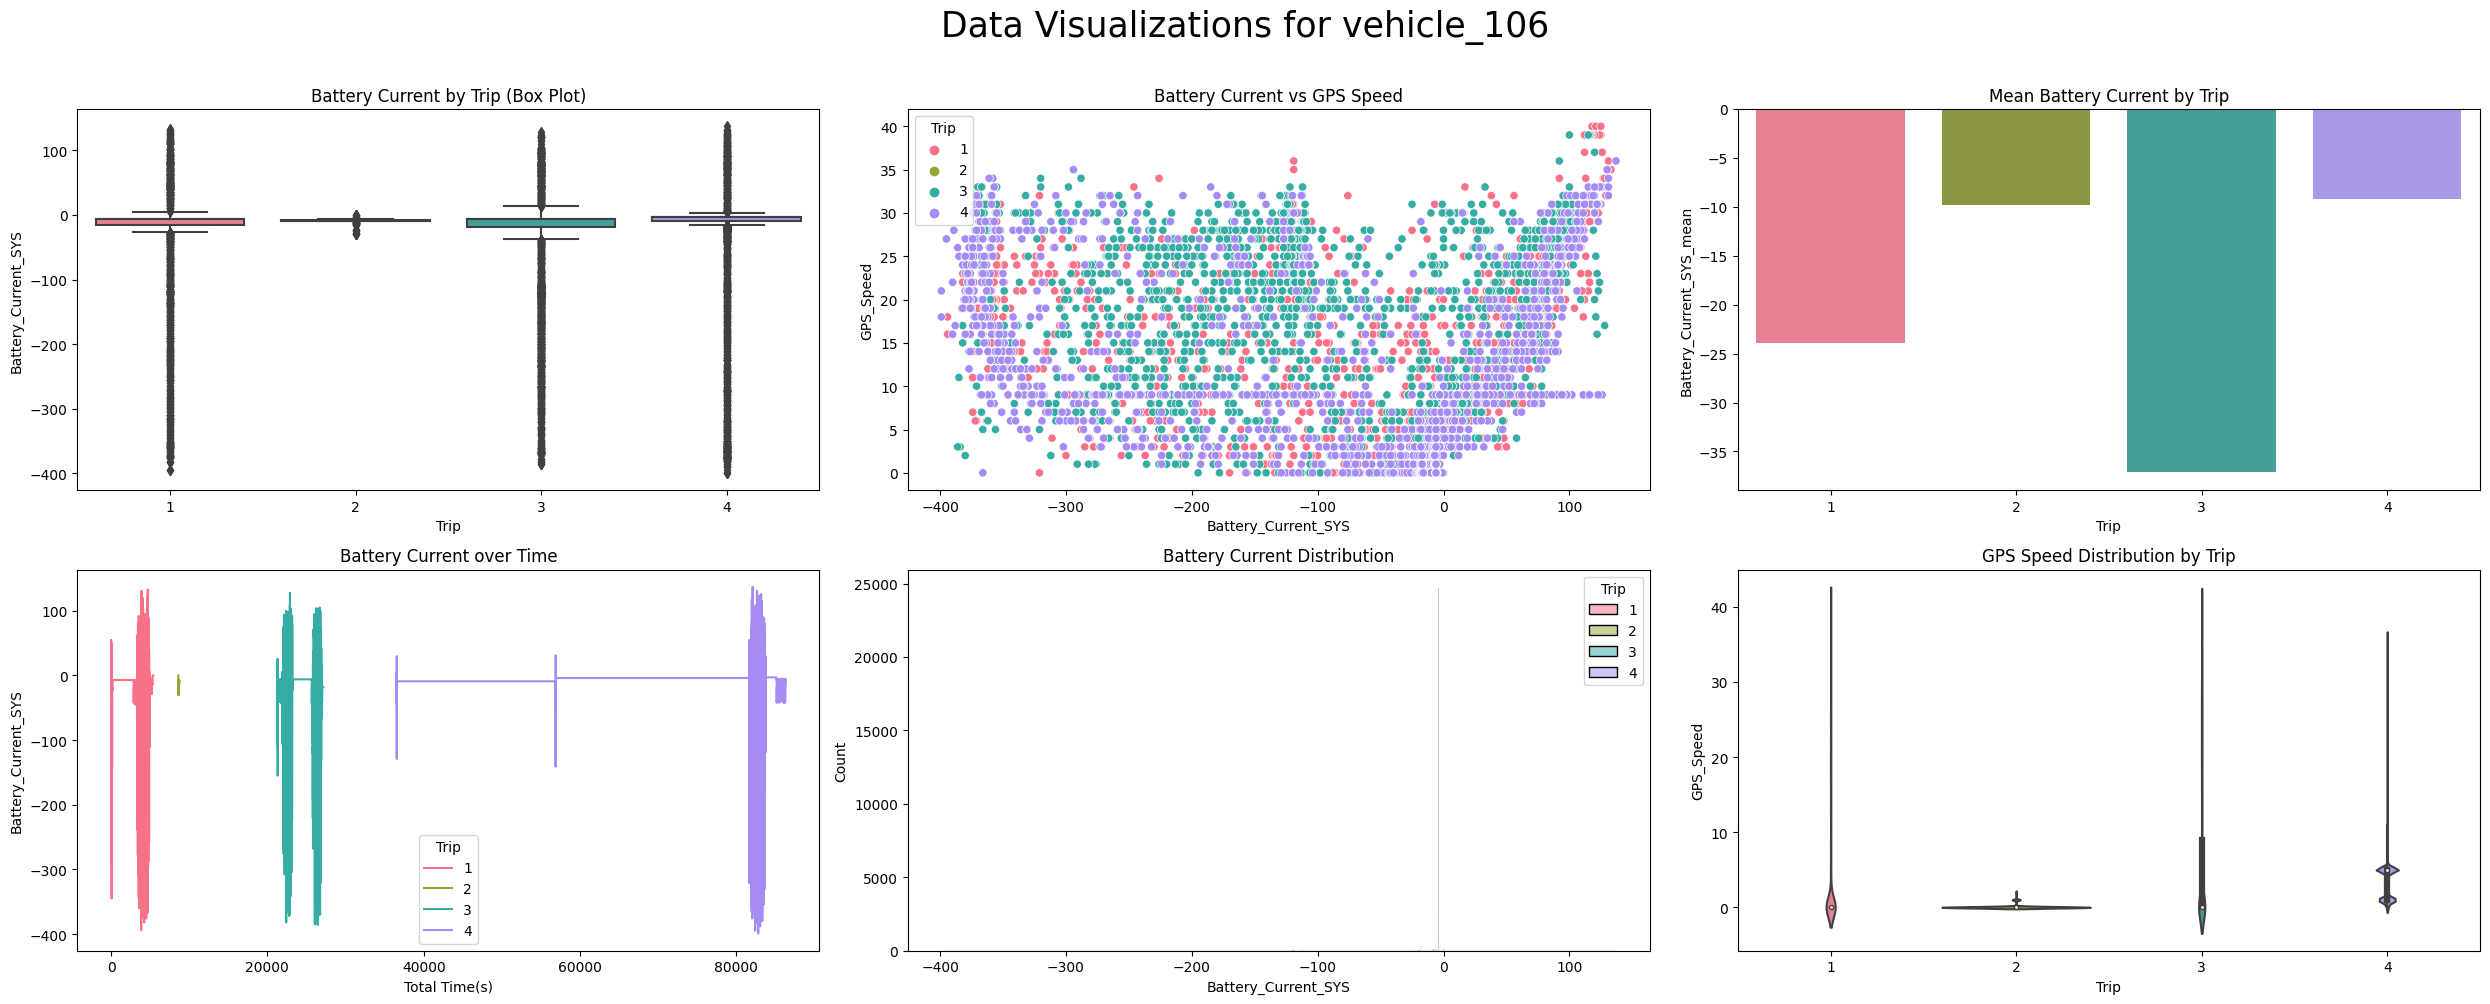

In [141]:
# Create subplots for each plot
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25,10))
palette = sns.color_palette("husl", len(df_trip["Trip"].unique()))

# Histogram
sns.boxplot(data=df_trip, x="Trip", y="Battery_Current_SYS", palette=palette, ax=axes[0,0])
axes[0,0].set_title("Battery Current by Trip (Box Plot)")

# Scatter plot
sns.scatterplot(data=df_trip, x="Battery_Current_SYS", y="GPS_Speed", hue="Trip", palette=palette, ax=axes[0,1])
axes[0,1].set_title("Battery Current vs GPS Speed")

# Bar plot
sns.barplot(data=df_statistics, x="Trip", y="Battery_Current_SYS_mean", palette=palette, ax=axes[0,2])
axes[0,2].set_title("Mean Battery Current by Trip")

# Additional plot 1
sns.lineplot(data=df_trip, x="Total Time(s)", y="Battery_Current_SYS", hue="Trip", palette=palette, ax=axes[1,0])
axes[1,0].set_title("Battery Current over Time")

# Additional plot 2
sns.histplot(data=df_trip, x="Battery_Current_SYS", hue="Trip", palette=palette, ax=axes[1,1])
axes[1,1].set_title("Battery Current Distribution")

# Additional plot 3
sns.violinplot(data=df_trip, x="Trip", y="GPS_Speed", palette=palette, ax=axes[1,2])
axes[1,2].set_title("GPS Speed Distribution by Trip")

# Add overall title
plt.suptitle("Data Visualizations for " + path_prefix[path_prefix.rfind("/")+1:], fontsize = 25, y= 1)

# Adjust layout and show
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


## 0.5. Merge multiple truck data files


In [2]:
path_prefix = "../Smith_Gen2 Vehicles Data/"

In [3]:
cols_to_keep = ['BMU_Mode_SYS','GPS_Speed','Battery_Voltage_SYS','Battery_Current_SYS','Timestamp','RD_Ambient_Temp_degC',
                'GPS_Altitude','GPS_Latitude', 'GPS_Longitude','CT_Air_Con_Current_RD']

In [4]:
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

def get_city(lat, lon):
    # NaN handler for lat and lon
    if np.isnan(lat) or np.isnan(lon):
        return None

    geolocator = Nominatim(user_agent="myGeocoder")
    try:
        location = geolocator.reverse((lat, lon), exactly_one=True)
        # Nominatim could not find the location for given lat & lon
        if location is None:
            return None
        # Get city, if there is no information put None
        return location.raw['address'].get('state', None)
    
    # No response for request, make a new request (might result in stack overflow) O(N) Algorithm
    except GeocoderTimedOut:
        return get_city(lat, lon)
    
    except ValueError:
        return None
       


In [27]:
df_list = [] # Initialize an empty list to store dataframes
# SEARCH_VEHICLE_FOLDER_COUNT = 0
STARTFOLDER = 25  #1 ilk dosya 0 degil
ENDFOLDER = 30   #30 son dosya

#we have 30 folders
vehicle_folder_counter = 0
removed_file_counter = 0


# Iterate over the directories and files in the path_prefix
for path, currentDirectory, files in os.walk(path_prefix):
    # Iterate over the files in the current directory
    if(STARTFOLDER > vehicle_folder_counter): 
        if(vehicle_folder_counter > 0):       #ilk okudugu folder bos empty string atiyor o yuzden if koydum bosuna printlemesin diye
            print(os.path.basename(path), "skipped")
        vehicle_folder_counter+=1
        continue
    
    elif(vehicle_folder_counter > ENDFOLDER):
        break
              
    print("Reading", os.path.basename(path) + "... ", end="")

    for file in files:
        if file.endswith('.mat'):
            try:
                mat = loadmat(join(path, file))

            except IOError:
                print(f"\nError reading file: {join(path, file)}")
                continue
                
            mat = {k: v for k, v in mat.items() if k[0] != '_'}
            df_temp = pd.DataFrame({k: np.array(v).flatten() for k, v in mat.items()})

            # selecting columns to keep
            df_temp = df_temp[cols_to_keep]
            
            # Large NaN Detection
            df_files_with_large_nan = df_temp[df_temp['BMU_Mode_SYS'] == 2.0]

            if(df_files_with_large_nan['RD_Ambient_Temp_degC'].isnull().mean() >= 0.50 or df_files_with_large_nan['GPS_Speed'].isnull().mean() >= 0.50 or 
                df_files_with_large_nan['Battery_Voltage_SYS'].isnull().mean() >= 0.50 or df_files_with_large_nan['Battery_Current_SYS'].isnull().mean() >= 0.50 or 
                df_files_with_large_nan['GPS_Altitude'].isnull().mean()>= 0.50):
            #      or df_files_with_large_nan['CT_Heater_Current_RD'].isnull().mean()>= 0.50 or 
            #    df_files_with_large_nan['CT_Air_Con_Current_RD'].isnull().mean()>= 0.50)
                removed_file_counter += 1

            else:
      
                if (df_temp[df_temp['BMU_Mode_SYS'] == 2.0].shape[0] < 5):                   
                    # print(file,'has less than 10 data on BMU_MODE=2')
                    continue
                
                else:
                    
                    # Convert the 'Timestamp' column to datetime
                    # Seconds[n] = Timestamp[n+1] - Timestamp[n]
                    df_temp['Timestamp'] = pd.to_datetime(df_temp['Timestamp'], unit='s')
                    df_temp['Seconds difference'] = df_temp['Timestamp'].diff().dt.total_seconds()
                    
                    df_temp['GPS_Altitude_diff'] = df_temp['GPS_Altitude'].diff()
                    # df_temp.at[0, "GPS_Altitude_diff"] = 0
                    
                    # Calculate the cumulative sum of the time differences
                    df_temp['Total Time(s)'] = df_temp['Seconds difference'].cumsum()
                    # df_temp.at[0, "Total Time(s)"] = 0 

                    # Convert GPS speed from mph to km/h
                    df_temp['GPS_Speed'] = df_temp['GPS_Speed'] * 1.60934

                    # Calculate the speed difference between consecutive timestamps
                    # Calculate acceleration (change in speed / change in time = m/s^2)
                    df_temp['Acceleration'] = (df_temp['GPS_Speed'] / 3.6).diff() / df_temp['Seconds difference']
                    
                    # Calculate power
                    df_temp['Power(kW)'] = (df_temp['Battery_Voltage_SYS'] * df_temp['Battery_Current_SYS'] * -1) / 1000

                    # Select BMU
                    df_temp = df_temp[df_temp['BMU_Mode_SYS'] == 2.0]
                
                    # Assign traffic categories to a new column 'Traffic_Category'
                    df_temp['Traffic_Category'] = df_temp['Timestamp'].dt.hour.apply(
                        lambda hour: 1 if 0 <= hour < 5 # Early Morning (12AM - 5AM): Low traffic
                        else 3 if 5 <= hour < 10        # Morning Rush Hour (5AM - 10AM): High traffic
                        else 2 if 10 <= hour < 15       # Midday (10AM - 3PM): Moderate traffic
                        else 3 if 15 <= hour < 20       # Evening Rush Hour (3PM - 8PM): High traffic
                        else 1)                         # Late Evening (8PM - 12AM): Low traffic

                    # Partition the data to trips by using Total Time(s)
                    # Assign trip numbers based on the difference in 'Total Time(s)'
                    df_temp['Trip_diff'] = df_temp["Total Time(s)"].diff()
                    df_temp["Trip"] = (df_temp['Trip_diff'] > 1000).cumsum() + 1

                    # Create a 'Trip_Seconds_Counter' column without adding intermediate columns to the DataFrame
                    df_temp['Trip_Seconds_Counter'] = (
                        df_temp['Trip'].ne(df_temp['Trip'].shift())
                        .cumsum()
                        .groupby(df_temp['Trip'])
                        .cumcount()
                    ) 
                    
                    # Finding the county name corresponding to the given average latitude and longitude values
                    # df_temp['City_Name'] = get_city(df_temp['GPS_Latitude'].mean(), df_temp['GPS_Longitude'].mean())  
                    
                    # DROPPING ANORMALIES First
                    df_temp.drop(df_temp[df_temp['GPS_Speed'] >= 55].index, inplace=True)
                    df_temp.drop(df_temp[df_temp['Battery_Voltage_SYS'] >= 360].index, inplace=True)
                    df_temp.drop(df_temp[df_temp['Power(kW)'] >= 88].index, inplace=True)
                    df_temp.drop(df_temp[df_temp['RD_Ambient_Temp_degC'] >= 36].index, inplace=True)
                    df_temp.drop(df_temp[df_temp['RD_Ambient_Temp_degC'] < -15].index, inplace=True)
                        
                    # Create the vehicle_name extracting from path 
                    # Insert the 'ID' and 'File_Name' columns 
                    df_temp["ID"] = os.path.basename(path) + '_' + file[file.rfind("_")+1:file.rfind(".")] + "_trip_" + df_temp["Trip"].astype(str)
                    df_temp["File_Name"] = os.path.basename(path) + '_' + file

                    # Drop the 'Unnecessary' column
                    df_temp = df_temp.dropna(subset=['Power(kW)']) 
                    df_temp = df_temp.drop(['Trip_diff'], axis=1)
                    df_temp = df_temp.drop(['Seconds difference'], axis=1)
                    df_temp = df_temp.drop(['BMU_Mode_SYS'], axis=1)
                    df_temp = df_temp.drop(['Trip'], axis=1)
                    df_temp = df_temp.drop(['Total Time(s)'], axis=1)
                    df_temp = df_temp.drop(['File_Name'], axis=1)

                    # Append the dataframe to the list
                    df_list.append(df_temp)
                    # print(file,u'\u2713')                              
    print(u'\u2713')
    vehicle_folder_counter += 1


# Merge all dataframes in the list
print(removed_file_counter, 'files removed due to high NaN ratio')
print("Merging the files... ")
df_merged = pd.concat(df_list)
print("Files have been merged", u'\u2713')

vehicle_106 skipped
vehicle_109 skipped
vehicle_113 skipped
vehicle_150 skipped
vehicle_163 skipped
vehicle_167 skipped
vehicle_173 skipped
vehicle_207 skipped
vehicle_214 skipped
vehicle_215 skipped
vehicle_217 skipped
vehicle_218 skipped
vehicle_275 skipped
vehicle_282 skipped
vehicle_330 skipped
vehicle_384 skipped
vehicle_385 skipped
vehicle_387 skipped
vehicle_396 skipped
vehicle_414 skipped
vehicle_418 skipped
vehicle_426 skipped
vehicle_429 skipped
vehicle_430 skipped
Reading vehicle_431... ✓
Reading vehicle_432... ✓
Reading vehicle_434... ✓
Reading vehicle_437... ✓
Reading vehicle_439... ✓
Reading vehicle_441... ✓
69 files removed due to high NaN ratio
Merging the files... 
Files have been merged ✓


In [28]:
df_merged.isna().sum()

GPS_Speed                271686
Battery_Voltage_SYS           0
Battery_Current_SYS           0
Timestamp                     0
RD_Ambient_Temp_degC      31581
GPS_Altitude             280077
GPS_Latitude             270754
GPS_Longitude            270756
CT_Air_Con_Current_RD    988421
GPS_Altitude_diff        282211
Acceleration             273816
Power(kW)                     0
Traffic_Category              0
Trip_Seconds_Counter          0
ID                            0
dtype: int64

In [29]:
df_merged.to_csv('df_merged_25-30.csv',index=False)

In [30]:
df_merged

,GPS_Speed,Battery_Voltage_SYS,Battery_Current_SYS,Timestamp,RD_Ambient_Temp_degC,GPS_Altitude,GPS_Latitude,GPS_Longitude,CT_Air_Con_Current_RD,GPS_Altitude_diff,Acceleration,Power(kW),Traffic_Category,Trip_Seconds_Counter,ID
3,NaN,346.0,-3.0,2013-01-10 02:05:13,14.0,NaN,NaN,NaN,2487.0,NaN,NaN,1.038,1,0,vehicle_431_2013-01-09_trip_1
4,NaN,346.0,-1.0,2013-01-10 02:05:14,14.0,NaN,NaN,NaN,2494.0,NaN,NaN,0.346,1,1,vehicle_431_2013-01-09_trip_1
5,NaN,346.0,0.0,2013-01-10 02:05:15,14.0,NaN,NaN,NaN,2487.0,NaN,NaN,-0.000,1,2,vehicle_431_2013-01-09_trip_1
6,NaN,346.0,0.0,2013-01-10 02:05:16,14.0,NaN,NaN,NaN,2494.0,NaN,NaN,-0.000,1,3,vehicle_431_2013-01-09_trip_1
7,NaN,346.0,-5.0,2013-01-10 02:05:17,14.0,NaN,NaN,NaN,2494.0,NaN,NaN,1.730,1,4,vehicle_431_2013-01-09_trip_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81585,0.0,344.0,-7.0,2015-01-12 05:39:57,-1.0,40.0,40.484219,-74.518949,NaN,0.0,0.0,2.408,3,184,vehicle_441_2015-01-11_trip_1
81586,0.0,344.0,-7.0,2015-01-12 05:39:58,-1.0,41.0,40.484220,-74.518949,NaN,1.0,0.0,2.408,3,185,vehicle_441_2015-01-11_trip_1
81587,0.0,344.0,-7.0,2015-01-12 05:39:59,-1.0,41.0,40.484217,-74.518949,NaN,0.0,0.0,2.408,3,186,vehicle_441_2015-01-11_trip_1
81588,0.0,344.0,-7.0,2015-01-12 05:40:00,-1.0,41.0,40.484219,-74.518950,NaN,0.0,0.0,2.408,3,187,vehicle_441_2015-01-11_trip_1


## 0.6. Groupby trips and create our real dataset

In [73]:
FILE_NAME = '1-6'
df_merged = pd.read_csv("../Yeni dosyalar/df_merged_{}.csv".format(FILE_NAME))

In [74]:
# Custom function to calculate trip metrics
city_dict = {}
def calculate_trip_metrics(df):
    
    # df['GPS_Speed'] = df['GPS_Speed'].ffill()
    # df['RD_Ambient_Temp_degC'] = df['RD_Ambient_Temp_degC'].ffill()
    # df['GPS_Altitude'] = df['GPS_Altitude'].ffill()
    # df['CT_Air_Con_Current_RD'] = df['CT_Air_Con_Current_RD'].ffill()
    # df['GPS_Altitude_diff'] = df['GPS_Altitude_diff'].ffill()
    # df['Acceleration'] = df['Acceleration'].ffill()
    # df['City_Name'] = df['City_Name'].ffill()
    
    
    # latitude = df['GPS_Latitude'].median().round(3)
    # longtitude = df['GPS_Longitude'].median().round(3)
    # coordinate = str(latitude)+'-'+str(longtitude)
    # if(coordinate in city_dict):
    #     city = city_dict[coordinate]
    # else:
    #     city = get_city(latitude, longtitude) 
    #     city_dict[coordinate] = city
    
    
    energy_consumption = np.trapz(y=df["Power(kW)"], x=df["Trip_Seconds_Counter"])
    energy_consumption_kwh = energy_consumption / 3600

    avg_temperature = df["RD_Ambient_Temp_degC"].mean()
    avg_speed_kmh = df["GPS_Speed"].mean(skipna=True)
    
    # df['GPS_Speed'].fillna(avg_speed_kmh, inplace=True)
    
    avg_traffic_category = df["Traffic_Category"].mean()
    avg_gps_altitude = df["GPS_Altitude"].mean()
    avg_air = df["CT_Air_Con_Current_RD"].mean()

    # Calculate separate means of positive and negative acceleration values, all of them in m/s^2
    positive_acceleration_mean = df[df["Acceleration"] > 0]["Acceleration"].mean()
    # negative_acceleration_mean = df[df["Acceleration"] < 0]["Acceleration"].mean()

    positive_acceleration_sum = df[df["Acceleration"] > 0]["Acceleration"].sum()
    # negative_acceleration_sum = df[df["Acceleration"] < 0]["Acceleration"].sum()
    
    positive_altitude_diff_mean = df[df["GPS_Altitude_diff"] > 0]["GPS_Altitude_diff"].mean()
    # negative_altitude_diff_mean = df[df["GPS_Altitude_diff"] < 0]["GPS_Altitude_diff"].mean()

    positive_altitude_diff_sum = df[df["GPS_Altitude_diff"] > 0]["GPS_Altitude_diff"].sum()
    # negative_altitude_diff_sum = df[df["GPS_Altitude_diff"] < 0]["GPS_Altitude_diff"].sum()

    # positive_altitude_diff_mean = gps_altitude_diff[gps_altitude_diff > 0].mean()
    # negative_altitude_diff_mean = gps_altitude_diff[gps_altitude_diff < 0].mean()
    
    # positive_altitude_diff_sum = gps_altitude_diff[gps_altitude_diff > 0].sum()
    # negative_altitude_diff_sum = gps_altitude_diff[gps_altitude_diff < 0].sum()

    # Get start time and end time for each trip
    start_time = df["Timestamp"].iloc[0]
    end_time = df["Timestamp"].iloc[-1]
     

    # Calculate max and min speed for each trip
    max_speed = df["GPS_Speed"].max()
    min_speed = df["GPS_Speed"].min()

    # max_altitude_diff = gps_altitude_diff.max()
    max_altitude_diff = df["GPS_Altitude_diff"].max()
    max_altitude = df["GPS_Altitude"].max()

    # min_altitude_diff = gps_altitude_diff.min()
    min_altitude_diff = df["GPS_Altitude_diff"].min()
    min_altitude = df["GPS_Altitude"].min()

    # Calculation of total distance in km
    duration = df["Trip_Seconds_Counter"].max()
    
    # gps_speed_kms = df["GPS_Speed"] / 3600
    # total_distance_km = np.trapz(y=gps_speed_kms, x=df["Trip_Seconds_Counter"])
    total_distance_km = (avg_speed_kmh / 3600) * duration
    total_distance_mph = total_distance_km / 1.60934
    
    df['Speed_mph'] = df["GPS_Speed"] / (1.60934)
    
    df["Trip_Seconds_Counter"] = df["Trip_Seconds_Counter"] / 3600
    
    characteristic_Acc = ( (df["Speed_mph"].shift(-1)**2  - df["Speed_mph"]**2) *0.5 + (9.8 * (df["GPS_Altitude"].shift(-1)-df["GPS_Altitude"]))).sum() / total_distance_mph
    
    aero = ((( df["Speed_mph"].shift(-1)**3 + df["Speed_mph"].shift(-1)**2 * df["Speed_mph"] + df["Speed_mph"].shift(-1) * df["Speed_mph"]**2 + df["Speed_mph"]**3 ) / 4 ) 
            * (df["Trip_Seconds_Counter"].shift(-1)-df["Trip_Seconds_Counter"])).sum() / total_distance_mph
    


    # Return the calculated metrics for the trip
    return {
        'Energy_Consumption_kWh': energy_consumption_kwh,
        'Start_Time': start_time,
        'End_Time': end_time,
        'Duration_s': duration,
        'Average_Speed_kmh' : avg_speed_kmh if not math.isnan(avg_speed_kmh) else 0,
        'Total_Distance_km': total_distance_km,
        # 'City_Name': city,

        'Max_Speed': max_speed,
        'Min_Speed': min_speed,

        'Positive_Acceleration_Mean': positive_acceleration_mean,
        'Positive_Acceleration_Sum': positive_acceleration_sum,
      
        'Positive_Altitude-diff_Mean': positive_altitude_diff_mean,
        'Positive_Altitude-diff_Sum': positive_altitude_diff_sum,
       

        'Max_Altitude-diff': max_altitude_diff,
        'Min_Altitude-diff': min_altitude_diff,
        'Max_Altitude': max_altitude,
        'Min_Altitude': min_altitude,
        'GPS_Altitude_Mean':avg_gps_altitude, 

        'Average_Ambient_Temperature': avg_temperature,
        'Average_air': avg_air,
        'Average_Ambient_Temperature': avg_temperature,
        'Characteristic_Acceleration': characteristic_Acc,
        'Kinetic_Intensity': characteristic_Acc / aero,
        'Traffic_Category_Mean': avg_traffic_category
    }

# Group the DataFrame by 'ID', apply the custom function, and store the result in a Series
trip_metrics = df_merged.groupby('ID').apply(calculate_trip_metrics)
trip_metrics_df = trip_metrics.apply(pd.Series).reset_index()

# Reset the index and print the total energy consumption
print('Total energy consumption:', trip_metrics_df["Energy_Consumption_kWh"].sum())
trip_metrics_df 

C:\Users\Yunus\AppData\Local\Temp\ipykernel_2752\1271815811.py:84: RuntimeWarning: divide by zero encountered in double_scalars
  characteristic_Acc = ( (df["Speed_mph"].shift(-1)**2  - df["Speed_mph"]**2) *0.5 + (9.8 * (df["GPS_Altitude"].shift(-1)-df["GPS_Altitude"]))).sum() / total_distance_mph
C:\Users\Yunus\AppData\Local\Temp\ipykernel_2752\1271815811.py:86: RuntimeWarning: invalid value encountered in double_scalars
  aero = ((( df["Speed_mph"].shift(-1)**3 + df["Speed_mph"].shift(-1)**2 * df["Speed_mph"] + df["Speed_mph"].shift(-1) * df["Speed_mph"]**2 + df["Speed_mph"]**3 ) / 4 )
C:\Users\Yunus\AppData\Local\Temp\ipykernel_2752\1271815811.py:84: RuntimeWarning: divide by zero encountered in double_scalars
  characteristic_Acc = ( (df["Speed_mph"].shift(-1)**2  - df["Speed_mph"]**2) *0.5 + (9.8 * (df["GPS_Altitude"].shift(-1)-df["GPS_Altitude"]))).sum() / total_distance_mph
C:\Users\Yunus\AppData\Local\Temp\ipykernel_2752\1271815811.py:86: RuntimeWarning: invalid value encounter

Total energy consumption: 93673.9032725


,ID,Energy_Consumption_kWh,Start_Time,End_Time,Duration_s,Average_Speed_kmh,Total_Distance_km,Max_Speed,Min_Speed,Positive_Acceleration_Mean,...,Max_Altitude-diff,Min_Altitude-diff,Max_Altitude,Min_Altitude,GPS_Altitude_Mean,Average_Ambient_Temperature,Average_air,Characteristic_Acceleration,Kinetic_Intensity,Traffic_Category_Mean
0,vehicle_106_2013-01-02_trip_1,56.512577,2013-01-02 17:03:03,2013-01-03 06:59:37,30054,3.059713,25.543506,53.10822,0.0,0.682558,...,141.0,-36.0,186.0,0.0,27.401732,-0.701630,2538.156197,32.138279,0.094478,2.167538
1,vehicle_106_2013-01-03_trip_1,67.325737,2013-01-03 07:00:39,2013-01-04 06:59:01,61184,5.406763,91.890939,54.71756,0.0,0.652998,...,106.0,-18.0,154.0,0.0,19.594187,0.645511,2509.308584,-4.814485,-0.027146,1.835317
2,vehicle_106_2013-01-04_trip_1,73.932923,2013-01-04 07:00:03,2013-01-05 06:45:37,65658,0.615856,11.232193,54.71756,0.0,0.654898,...,19.0,-25.0,100.0,0.0,14.865846,2.540228,2507.926606,99.693687,0.191294,1.923882
3,vehicle_106_2013-01-05_trip_1,-113.205677,2013-01-05 07:12:24,2013-01-06 01:34:20,52863,18.642805,273.754051,54.71756,0.0,0.620325,...,82.0,-134.0,405.0,0.0,56.241256,4.485057,2517.485382,-6.452550,-0.015366,2.153184
4,vehicle_106_2013-01-07_trip_1,0.082100,2013-01-08 03:24:30,2013-01-08 06:59:59,12929,0.000875,0.003143,1.60934,0.0,0.447039,...,3.0,-4.0,55.0,0.0,20.422091,8.330394,2499.255762,65241.277748,91728.000000,2.113689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2226,vehicle_167_2015-01-06_trip_1,25.799600,2015-01-06 08:10:33,2015-01-07 00:52:32,5949,13.630896,22.525056,54.71756,0.0,0.591020,...,54.0,-52.0,262.0,183.0,206.688458,-10.771400,11.437447,14.667999,0.022555,2.038747
2227,vehicle_167_2015-01-07_trip_1,0.185205,2015-01-08 03:50:14,2015-01-08 06:28:06,86,2.275274,0.054354,12.87472,0.0,0.484292,...,1.0,-1.0,213.0,208.0,210.896552,-13.000000,6.000000,870.493477,24.519866,1.298851
2228,vehicle_167_2015-01-08_trip_1,28.034863,2015-01-08 15:33:55,2015-01-09 04:37:36,5131,14.740880,21.009849,54.71756,0.0,0.560000,...,53.0,-56.0,256.0,178.0,203.902680,-13.063671,10.294834,2.252020,0.003543,2.088052
2229,vehicle_167_2015-01-09_trip_1,26.907276,2015-01-09 07:32:20,2015-01-10 05:15:09,5175,15.542853,22.342851,54.71756,0.0,0.583141,...,50.0,-41.0,256.0,177.0,203.060220,-7.173006,43.230739,-2.117662,-0.003694,1.597276


In [ ]:
temp_metric = pd.read_csv("../Yeni dosyalar/trip_metrics_{}.csv".format(FILE_NAME))
temp_metric

In [ ]:
trip_metrics_df = pd.merge(trip_metrics_df, temp_metric[['ID', 'City_Name']], on='ID', how='left')
# trip_metrics_df = trip_metrics_df.rename(columns={"City_Name": "State_Name"})
trip_metrics_df

In [70]:
trip_metrics_df.to_csv('trip_metrics_{}.csv'.format(FILE_NAME),index=False)

## 0.7. Merge all trip_metrics

In [ ]:
trip_metrics_1 = pd.read_csv("../Yeni dosyalar/trip_metrics_1-6.csv")
trip_metrics_2 = pd.read_csv("../Yeni dosyalar/trip_metrics_7-12.csv")
trip_metrics_3 = pd.read_csv("../Yeni dosyalar/trip_metrics_13-18.csv")
trip_metrics_4 = pd.read_csv("../Yeni dosyalar/trip_metrics_19-24.csv")
trip_metrics_5 = pd.read_csv("../Yeni dosyalar/trip_metrics_25-30.csv")

df_list = [trip_metrics_1,trip_metrics_2,trip_metrics_3,trip_metrics_4,trip_metrics_5]
trips_merged = pd.concat(df_list)
trips_merged.to_csv('trips_merged.csv',index=False)
trips_merged


In [137]:
# if you have all data just use this method
trips_merged = pd.read_csv("../Yeni dosyalar/trips_merged.csv")
trips_merged

,ID,Energy_Consumption_kWh,Start_Time,End_Time,Duration_s,Average_Speed_kmh,Total_Distance_km,Max_Speed,Min_Speed,Positive_Acceleration_Mean,...,Min_Altitude-diff,Max_Altitude,Min_Altitude,GPS_Altitude_Mean,Average_Ambient_Temperature,Average_air,Characteristic_Acceleration,Kinetic_Intensity,Traffic_Category_Mean,State_Name
0,vehicle_106_2013-01-02_trip_1,56.512577,2013-01-02 17:03:03,2013-01-03 06:59:37,30054,3.059713,25.543506,53.10822,0.0,0.682558,...,-36.0,186.0,0.0,27.401732,-0.701630,2538.156197,32.138279,0.094478,2.167538,New York
1,vehicle_106_2013-01-03_trip_1,67.325737,2013-01-03 07:00:39,2013-01-04 06:59:01,61184,5.406763,91.890939,54.71756,0.0,0.652998,...,-18.0,154.0,0.0,19.594187,0.645511,2509.308584,-4.814485,-0.027146,1.835317,New York
2,vehicle_106_2013-01-04_trip_1,73.932923,2013-01-04 07:00:03,2013-01-05 06:45:37,65658,0.615856,11.232193,54.71756,0.0,0.654898,...,-25.0,100.0,0.0,14.865846,2.540228,2507.926606,99.693687,0.191294,1.923882,New York
3,vehicle_106_2013-01-05_trip_1,-113.205677,2013-01-05 07:12:24,2013-01-06 01:34:20,52863,18.642805,273.754051,54.71756,0.0,0.620325,...,-134.0,405.0,0.0,56.241256,4.485057,2517.485382,-6.452550,-0.015366,2.153184,New York
4,vehicle_106_2013-01-07_trip_1,0.082100,2013-01-08 03:24:30,2013-01-08 06:59:59,12929,0.000875,0.003143,1.60934,0.0,0.447039,...,-4.0,55.0,0.0,20.422091,8.330394,2499.255762,65241.277748,91728.000000,2.113689,New York
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10314,vehicle_441_2015-01-07_trip_1,48.259822,2015-01-07 09:16:14,2015-01-08 01:38:05,6153,30.360591,51.891309,54.71756,0.0,0.615739,...,-37.0,118.0,0.0,25.376619,-6.627231,NaN,-0.303934,-0.000381,1.809065,New Jersey
10315,vehicle_441_2015-01-08_trip_1,50.762781,2015-01-08 07:40:24,2015-01-09 01:09:45,6965,28.826084,55.770466,54.71756,0.0,0.601900,...,-43.0,94.0,0.0,25.596772,-10.669776,NaN,-0.565587,-0.000774,1.791352,New Jersey
10316,vehicle_441_2015-01-09_trip_1,44.076312,2015-01-09 07:02:21,2015-01-10 01:01:30,5877,27.029152,44.125091,54.71756,0.0,0.625577,...,-23.0,103.0,0.0,28.478131,-3.154897,NaN,-8.202602,-0.008253,1.778323,New Jersey
10317,vehicle_441_2015-01-10_trip_1,41.304916,2015-01-10 09:12:36,2015-01-11 00:05:32,6125,23.705111,40.331612,54.71756,0.0,0.615101,...,-57.0,123.0,0.0,29.333582,-8.270477,NaN,13.646722,0.014555,1.676657,New Jersey


In [ ]:
trips_merged.isna().sum()

## 0.8. Splitting the data to train test

In [139]:
trips_merged['Energy_Consumption_kWh'] = trips_merged['Energy_Consumption_kWh'] / trips_merged['Total_Distance_km']
trips_merged = trips_merged.rename(columns={"Energy_Consumption_kWh": "Energy_Consumption_kWh/km"})

In [141]:
state_dict = ['Nebraska','内蒙古自治区','Алматы облысы','Pays de la Loire','Comunitat Valenciana', None]
trips_merged['State_Name']  = trips_merged['State_Name'].replace(state_dict, 'Unknown')
trips_merged['State_Name'].unique()

array(['New York', 'Unknown', 'Indiana', 'Missouri', 'California',
       'Washington', 'Arizona', 'Maryland', 'District of Columbia',
       'New Jersey', 'Illinois', 'Michigan', 'Wisconsin', 'Virginia'],
      dtype=object)

In [143]:
trips_merged = trips_merged.dropna()
trips_merged.isna().sum()

In [145]:
X = trips_merged.drop(['Energy_Consumption_kWh/km', 'ID','Start_Time', 'End_Time','Total_Distance_km','Min_Speed'], axis=1)

y = trips_merged['Energy_Consumption_kWh/km']


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=55, stratify=X['State_Name'])

C:\Users\Yunus\AppData\Local\Temp\ipykernel_15116\2050606462.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(trips_merged.drop(columns=["ID", "City_Name", 'Min_Speed']).corr(), cmap="YlGnBu")


<Axes: >

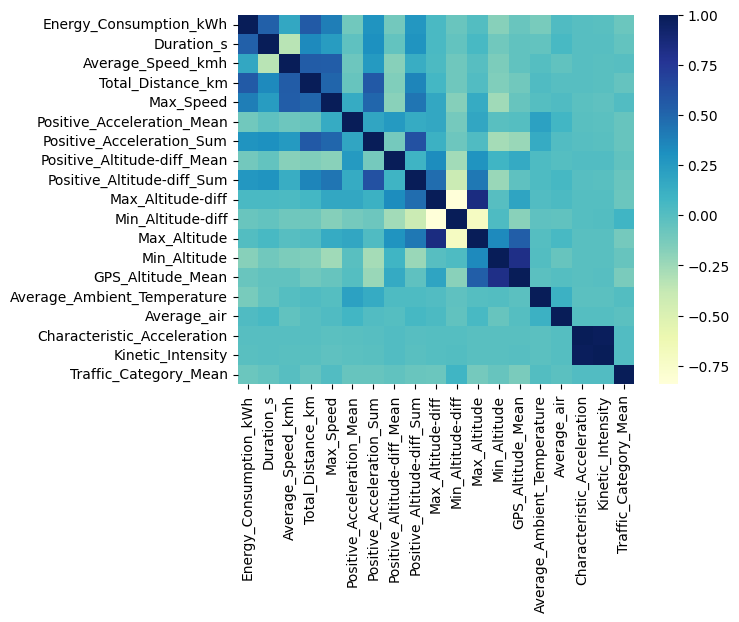

In [87]:
sns.heatmap(trips_merged.drop(columns=["ID", "City_Name", 'Min_Speed']).corr(), cmap="YlGnBu")

In [ ]:
trip_metrics_df.drop(columns=["ID", "City_Name"]).corr()

## 0.8. Feature Enginnering

In [88]:
trips_merged = trips_merged.rename(columns={"City_Name": "State_Name"})
trips_merged['State_Name'].unique()

array(['New York', 'Nebraska', 'Indiana', 'Missouri', 'California',
       'Washington', '内蒙古自治区', 'Алматы облысы', 'Arizona',
       'Pays de la Loire', 'Maryland', 'District of Columbia',
       'New Jersey', 'Illinois', 'Michigan', 'Wisconsin', 'Virginia',
       'Comunitat Valenciana'], dtype=object)

In [89]:
trips_merged = pd.get_dummies(trips_merged, columns=['State_Name'], prefix="",prefix_sep="") 

In [107]:
trips_merged['Energy_Consumption_kWh'] = trips_merged['Energy_Consumption_kWh'] / trips_merged['Total_Distance_km']
trips_merged = trips_merged.rename(columns={"Energy_Consumption_kWh": "Energy_Consumption_kWh/km"})

In [121]:
trips_merged

,ID,Energy_Consumption_kWh/km,Start_Time,End_Time,Duration_s,Average_Speed_kmh,Total_Distance_km,Max_Speed,Min_Speed,Positive_Acceleration_Mean,...,Missouri,Nebraska,New Jersey,New York,Pays de la Loire,Virginia,Washington,Wisconsin,Алматы облысы,内蒙古自治区
0,vehicle_106_2013-01-02_trip_1,2.212405,2013-01-02 17:03:03,2013-01-03 06:59:37,30054,3.059713,25.543506,53.10822,0.0,0.682558,...,0,0,0,1,0,0,0,0,0,0
1,vehicle_106_2013-01-03_trip_1,0.732670,2013-01-03 07:00:39,2013-01-04 06:59:01,61184,5.406763,91.890939,54.71756,0.0,0.652998,...,0,0,0,1,0,0,0,0,0,0
2,vehicle_106_2013-01-04_trip_1,6.582234,2013-01-04 07:00:03,2013-01-05 06:45:37,65658,0.615856,11.232193,54.71756,0.0,0.654898,...,0,0,0,1,0,0,0,0,0,0
3,vehicle_106_2013-01-05_trip_1,-0.413531,2013-01-05 07:12:24,2013-01-06 01:34:20,52863,18.642805,273.754051,54.71756,0.0,0.620325,...,0,0,0,1,0,0,0,0,0,0
4,vehicle_106_2013-01-07_trip_1,26.124524,2013-01-08 03:24:30,2013-01-08 06:59:59,12929,0.000875,0.003143,1.60934,0.0,0.447039,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,vehicle_441_2014-12-05_trip_1,1.046567,2014-12-05 07:01:28,2014-12-06 06:36:37,7763,20.488175,44.180473,54.71756,0.0,0.618775,...,0,0,1,0,0,0,0,0,0,0
2201,vehicle_441_2014-12-06_trip_1,0.996043,2014-12-06 07:17:32,2014-12-07 00:01:22,5249,26.268570,38.301034,54.71756,0.0,0.661012,...,0,0,1,0,0,0,0,0,0,0
2202,vehicle_441_2014-12-07_trip_1,1.266759,2014-12-07 23:11:49,2014-12-08 00:09:51,175,11.704291,0.568959,24.14010,0.0,0.679872,...,0,0,1,0,0,0,0,0,0,0
2210,vehicle_441_2014-12-15_trip_1,0.956629,2014-12-15 16:41:35,2014-12-16 06:12:01,6655,26.558385,49.096126,54.71756,0.0,0.635181,...,0,0,1,0,0,0,0,0,0,0


## 0.9. Divide model to train test

In [122]:
X = trips_merged.drop(['Energy_Consumption_kWh/km', 'ID','Start_Time', 'End_Time','Total_Distance_km','Min_Speed'], axis=1)

# X = df_train.drop(['moved_after_2019', 'stayed_more_than_avg','user_id'], axis=1)

y = trips_merged['Energy_Consumption_kWh/km']


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=55, stratify=y)

In [146]:
clf = XGBRegressor()
clf.fit(X_train, y_train)
predictions = classifier.predict(X_test)

c:\Users\Yunus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:1000: RuntimeWarning: invalid value encountered in divide
  y_hat /= len(self.estimators_)


In [143]:
df_temp = pd.DataFrame(y_test)
df_temp['predictions'] = predictions.tolist()
df_temp

,Energy_Consumption_kWh/km,predictions
805,0.821586,1.023858
1194,0.687071,0.775054
1210,1.597353,1.817607
1992,1.148355,1.115686
719,1.010047,1.096319
...,...,...
288,1.264817,1.447963
436,0.793230,0.990315
23,1.120804,1.214376
2212,1.417151,1.016770


## 0.7. Find the outliers and nan values

In [ ]:
def plot_histogram(nan_ratios, columns):
    plt.figure(figsize=(4, 2))
    plt.bar(columns, nan_ratios)
    plt.xlabel('Features')
    plt.ylabel('NaN Ratios (%)')
    plt.xticks(rotation=45, ha='right')
    plt.title('Histogram of NaN Ratios')
    plt.show()


def display_nan_ratios(df, columns=['GPS_Speed', 'Battery_Voltage_SYS', 'Battery_Current_SYS', 'Timestamp', 'RD_Ambient_Temp_degC', 'Total Time(s)', 'Power(kW)']):
    nan_ratios = []
    for col in columns:
        col_nan_ratio = df[col].isna().sum() / df.shape[0] * 100
        nan_ratios.append(col_nan_ratio)
        print(f"{col} NaN ratio = {col_nan_ratio:.3f} %")
        
    plot_histogram(nan_ratios, columns)

display_nan_ratios(df_merged)


In [ ]:
def nan_ratio(x):
    nan_count = x.isna().sum()
    not_nan_count = x.notna().sum()
    ratio = nan_count / (nan_count + not_nan_count)
    return ratio


In [ ]:
# groupby ID and calculate NaN ratio for Col1 and Col2
grouped = df_merged.groupby('File_Name', as_index=False)[['GPS_Speed', 'Battery_Voltage_SYS','Battery_Current_SYS', 'RD_Ambient_Temp_degC']].apply(nan_ratio)
grouped = grouped.sort_values(by=['RD_Ambient_Temp_degC','GPS_Speed','Battery_Voltage_SYS','Battery_Current_SYS'], ascending=False)

In [ ]:
grouped.to_csv('nan_values.csv',index=False)

In [ ]:
def outlier_speed(x,y):
    outlier_count = (x > 50).sum()
    ratio = outlier_count / y
    return ratio

group_s = df_merged.groupby('File_Name', as_index=False)[['GPS_Speed']].apply(outlier_speed,df_merged.shape[0])
group_s

,File_Name,GPS_Speed
0,vehicle_106_device_06A_2013-01-02.mat,0.000012
1,vehicle_106_device_06A_2013-01-03.mat,0.000012
2,vehicle_106_device_06A_2013-01-04.mat,0.000027
3,vehicle_106_device_06A_2013-01-05.mat,0.000083
4,vehicle_106_device_06A_2013-01-07.mat,0.000000
...,...,...
710,vehicle_113_device_071_2014-12-08.mat,0.000079
711,vehicle_113_device_071_2014-12-09.mat,0.000158
712,vehicle_113_device_071_2014-12-16.mat,0.000130
713,vehicle_113_device_071_2014-12-17.mat,0.000033


In [ ]:
group_s.to_csv('speed_anomaly.csv',index=False)

In [ ]:
def outlier_voltage(x,y):
    outlier_count = (x > 346).sum()
    ratio = outlier_count / y
    return ratio

group_v = df_merged.groupby('File_Name', as_index=False)[['Battery_Voltage_SYS']].apply(outlier_voltage,df_merged.shape[0])
group_v

,File_Name,Battery_Voltage_SYS
0,vehicle_106_device_06A_2013-01-02.mat,0.0
1,vehicle_106_device_06A_2013-01-03.mat,0.0
2,vehicle_106_device_06A_2013-01-04.mat,0.0
3,vehicle_106_device_06A_2013-01-05.mat,0.0
4,vehicle_106_device_06A_2013-01-07.mat,0.0
...,...,...
710,vehicle_113_device_071_2014-12-08.mat,0.0
711,vehicle_113_device_071_2014-12-09.mat,0.0
712,vehicle_113_device_071_2014-12-16.mat,0.0
713,vehicle_113_device_071_2014-12-17.mat,0.0


In [ ]:
group_v.to_csv('voltage_anomaly.csv',index=False)

In [ ]:
def outlier_power(x,y):
    outlier_count = (x > 80).sum()
    ratio = outlier_count / y
    return ratio

group_p = df_merged.groupby('File_Name', as_index=False)[['Power(kW)']].apply(outlier_power,df_merged.shape[0])
group_p

,File_Name,Power(kW)
0,vehicle_106_device_06A_2013-01-02.mat,0.000102
1,vehicle_106_device_06A_2013-01-03.mat,0.000130
2,vehicle_106_device_06A_2013-01-04.mat,0.000053
3,vehicle_106_device_06A_2013-01-05.mat,0.000075
4,vehicle_106_device_06A_2013-01-07.mat,0.000000
...,...,...
710,vehicle_113_device_071_2014-12-08.mat,0.000077
711,vehicle_113_device_071_2014-12-09.mat,0.000058
712,vehicle_113_device_071_2014-12-16.mat,0.000057
713,vehicle_113_device_071_2014-12-17.mat,0.000009


In [ ]:
group_p.to_csv('power_anomaly.csv',index=False)

In [ ]:
def outlier_temp(x,y):
    outlier_count = (x > 36).sum() + (x < -15).sum()
    ratio = outlier_count / y
    return ratio

group_t = df_merged.groupby('File_Name', as_index=False)[['RD_Ambient_Temp_degC']].apply(outlier_temp,df_merged.shape[0])
group_t.sort_values(by=['RD_Ambient_Temp_degC'], ascending=False)


,File_Name,RD_Ambient_Temp_degC
0,vehicle_106_device_06A_2013-01-02.mat,0.0
491,vehicle_106_device_06A_2014-10-23.mat,0.0
471,vehicle_106_device_06A_2014-09-27.mat,0.0
472,vehicle_106_device_06A_2014-09-29.mat,0.0
473,vehicle_106_device_06A_2014-09-30.mat,0.0
...,...,...
240,vehicle_106_device_06A_2013-11-13.mat,0.0
241,vehicle_106_device_06A_2013-11-14.mat,0.0
242,vehicle_106_device_06A_2013-11-15.mat,0.0
243,vehicle_106_device_06A_2013-11-16.mat,0.0


In [ ]:
group_t.to_csv('temp_anomaly.csv',index=False)

In [ ]:
# Get a list of column names
column_names = df_merged.columns.tolist()

# Move 'File' and 'ID' columns to the front of the list
column_names.insert(0, column_names.pop(column_names.index('File_Name')))
column_names.insert(1, column_names.pop(column_names.index('ID')))

# Reorder the DataFrame columns using the updated list
df_merged = df_merged[column_names]
